## Importing Required Libraries

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.constraints import unit_norm, max_norm
import tensorflow as tf
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

In [15]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import tensorflow as tf

## Reparameterization Trick Function

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropi
    c unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [17]:
import csv
import numpy as np

# Constants
h = 12.5
L = 1
Tsurr = 298
l_values = np.arange(0, 1.1, 0.1)

# Function to calculate T(l)
def calculate_T(l, q, k, h, L, Tsurr):
    return q * ((L - l) / k + 1 / h) + Tsurr

# Generate 1000 rows of data
data = []

for _ in range(1000):
    q = np.random.uniform(1000, 1100)
    k = np.random.uniform(10, 200)
    q_std = 0.05 * q
    k_std = 0.05 * k
    q_log_var = np.log(q_std ** 2)
    k_log_var = np.log(k_std ** 2)
    row = [calculate_T(l, q, k, h, L, Tsurr) for l in l_values]
    row.extend([q, k, q_log_var, k_log_var])
    data.append(row)

# Column names
columns = [f'x{i+1}' for i in range(len(l_values))]
columns.extend(['q', 'k', 'q_log_var', 'k_log_var'])

# Write data to CSV file
with open('Temp_data2parameter.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the column headers
    writer.writerow(columns)

    # Write the data rows
    writer.writerows(data)

print("Data written to Temp_data2parameter.csv")

Data written to Temp_data2parameter.csv


##Dataset for Two parameter estimation is generated using above equation where we consider different random values of k and q and these are also the parameters to be estimated and we get temperature values at 11 different points along the length of slab

## Importing the Dataset

In [18]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

data = pd.read_csv('/content/Temp_data2parameter.csv')
data = pd.DataFrame(data)
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,q,k,q_log_var,k_log_var
0,391.549903,390.926151,390.302398,389.678646,389.054893,388.431140,387.807388,387.183635,386.559883,385.936130,385.312377,1091.404718,174.973976,7.998977,4.337810
1,387.310031,386.448785,385.587540,384.726295,383.865050,383.003805,382.142560,381.281315,380.420070,379.558825,378.697580,1008.719745,117.123425,7.841410,3.534992
2,413.373593,409.837877,406.302161,402.766445,399.230728,395.695012,392.159296,388.623580,385.087864,381.552147,378.016431,1000.205390,28.288622,7.824457,0.693455
3,474.093904,465.109339,456.124773,447.140208,438.155643,429.171077,420.186512,411.201947,402.217381,393.232816,384.248250,1078.103130,11.999502,7.974452,-1.021734
4,398.442909,396.405557,394.368205,392.330853,390.293501,388.256149,386.218798,384.181446,382.144094,380.106742,378.069390,1000.867371,49.125895,7.825780,1.797308


## Original Data without Noise

In [19]:
original_data_without_noise = data.iloc[:,:-4]
original_data_without_noise.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,391.549903,390.926151,390.302398,389.678646,389.054893,388.431140,387.807388,387.183635,386.559883,385.936130,385.312377
1,387.310031,386.448785,385.587540,384.726295,383.865050,383.003805,382.142560,381.281315,380.420070,379.558825,378.697580
2,413.373593,409.837877,406.302161,402.766445,399.230728,395.695012,392.159296,388.623580,385.087864,381.552147,378.016431
3,474.093904,465.109339,456.124773,447.140208,438.155643,429.171077,420.186512,411.201947,402.217381,393.232816,384.248250
4,398.442909,396.405557,394.368205,392.330853,390.293501,388.256149,386.218798,384.181446,382.144094,380.106742,378.069390


## Adding Noise in the dataset (In the independent features/Temperature Distribution)

In [20]:
# Percentage of the standard deviation to be used for noise
percentage_std = 5 / 100

# Calculate standard deviations for each column
std_devs = original_data_without_noise.std()

# Generate noise for each element based on 5% of the column's standard deviation
noise = pd.DataFrame()
for column in original_data_without_noise.columns:
    column_noise = np.random.normal(0, std_devs[column] * percentage_std, size=original_data_without_noise.shape[0])
    noise[column] = column_noise

# Add the noise to the original data
original_data_with_noise = original_data_without_noise + noise

# Show the modified DataFrame
print(original_data_with_noise.head())

           x1          x2          x3          x4          x5          x6  \
0  390.351654  391.510429  389.952816  390.036760  389.043240  389.114622   
1  389.026471  386.311778  384.799418  384.450841  383.488086  382.948776   
2  413.207334  408.702608  406.177189  402.581201  399.154821  395.467920   
3  472.494764  463.939532  455.439382  448.051218  438.874536  429.259753   
4  398.171521  396.569768  394.032562  393.358224  389.672617  388.621340   

           x7          x8          x9         x10         x11  
0  387.823191  387.536453  386.508817  386.003755  385.155785  
1  382.336739  380.926805  380.643532  379.635596  378.534467  
2  392.726944  389.235336  385.089058  381.634249  378.058410  
3  420.077858  411.239748  402.072887  393.149973  384.462774  
4  385.901102  384.316534  382.115538  380.021403  378.079258  


## Combined Dataset

In [21]:
data_without_noise = pd.concat([original_data_without_noise, data.iloc[:,[-4,-3,-2,-1]]], axis=1)
print(data_without_noise)

             x1          x2          x3          x4          x5          x6  \
0    391.549903  390.926151  390.302398  389.678646  389.054893  388.431140   
1    387.310031  386.448785  385.587540  384.726295  383.865050  383.003805   
2    413.373593  409.837877  406.302161  402.766445  399.230728  395.695012   
3    474.093904  465.109339  456.124773  447.140208  438.155643  429.171077   
4    398.442909  396.405557  394.368205  392.330853  390.293501  388.256149   
..          ...         ...         ...         ...         ...         ...   
995  388.376925  387.830072  387.283219  386.736365  386.189512  385.642659   
996  395.149028  393.860355  392.571682  391.283009  389.994336  388.705663   
997  436.416894  430.752205  425.087516  419.422827  413.758138  408.093449   
998  387.144789  386.582603  386.020417  385.458231  384.896045  384.333859   
999  385.226293  384.558673  383.891054  383.223435  382.555816  381.888197   

             x7          x8          x9         x10

In [22]:
data = pd.concat([original_data_with_noise, data.iloc[:,[-4,-3,-2,-1]]], axis=1)
print(data)

             x1          x2          x3          x4          x5          x6  \
0    390.351654  391.510429  389.952816  390.036760  389.043240  389.114622   
1    389.026471  386.311778  384.799418  384.450841  383.488086  382.948776   
2    413.207334  408.702608  406.177189  402.581201  399.154821  395.467920   
3    472.494764  463.939532  455.439382  448.051218  438.874536  429.259753   
4    398.171521  396.569768  394.032562  393.358224  389.672617  388.621340   
..          ...         ...         ...         ...         ...         ...   
995  388.964076  387.085972  388.264466  386.405887  386.121140  385.143535   
996  395.631647  394.238720  393.007685  390.752564  389.333869  388.876951   
997  437.012785  430.904553  424.807255  418.796774  413.405260  408.212481   
998  387.224789  386.942482  385.225520  384.988522  384.556480  385.116430   
999  385.931099  384.492777  384.135291  382.834636  382.339917  381.775775   

             x7          x8          x9         x10

In [23]:
std_devs

x1     16.187177
x2     14.606685
x3     13.030608
x4     11.460768
x5      9.900133
x6      8.353863
x7      6.831719
x8      5.354317
x9      3.971901
x10     2.827411
x11     2.307264
dtype: float64

In [24]:
noise

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,-1.198249,0.584279,-0.349583,0.358115,-0.011653,0.683482,0.015803,0.352818,-0.051066,0.067625,-0.156593
1,1.716441,-0.137008,-0.788123,-0.275454,-0.376965,-0.055029,0.194179,-0.354510,0.223462,0.076772,-0.163113
2,-0.166259,-1.135269,-0.124972,-0.185244,-0.075907,-0.227092,0.567648,0.611756,0.001194,0.082102,0.041979
3,-1.599140,-1.169807,-0.685392,0.911010,0.718893,0.088676,-0.108654,0.037801,-0.144495,-0.082843,0.214523
4,-0.271388,0.164210,-0.335644,1.027371,-0.620884,0.365191,-0.317696,0.135088,-0.028556,-0.085339,0.009868
...,...,...,...,...,...,...,...,...,...,...,...
995,0.587151,-0.744100,0.981247,-0.330479,-0.068372,-0.499123,-0.524935,-0.010534,0.159111,-0.033935,-0.205651
996,0.482619,0.378365,0.436003,-0.530445,-0.660467,0.171288,-0.030841,-0.390149,0.179579,-0.107984,-0.107762
997,0.595890,0.152348,-0.280261,-0.626053,-0.352878,0.119032,0.182717,-0.188465,-0.132373,-0.103804,0.001159
998,0.080000,0.359879,-0.794897,-0.469709,-0.339565,0.782571,-0.314782,-0.456292,0.089622,0.125269,0.119033


In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_and_store_params(df):
    scaler = StandardScaler()
    standardized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    # Storing means and scales (standard deviations)
    params = {
        'mean': scaler.mean_,
        'scale': scaler.scale_
    }
    return standardized_df, params

# Standardizing and storing parameters
standardized_df, params = standardize_and_store_params(data)
print("Standardized DataFrame:")
print(standardized_df)
print("\nStored Parameters:")
print(params)

Standardized DataFrame:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.485018 -0.350181 -0.384067 -0.285139 -0.268990 -0.117711 -0.094353   
1   -0.567053 -0.705513 -0.778840 -0.771145 -0.830512 -0.854191 -0.897297   
2    0.929860  0.824917  0.858791  0.806299  0.753101  0.641158  0.623313   
3    4.600041  4.600400  4.632493  4.762449  4.768020  4.677422  4.626129   
4   -0.000930 -0.004372 -0.071541  0.003848 -0.205372 -0.176631 -0.375652   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.570915 -0.652596 -0.513402 -0.601045 -0.564359 -0.592038 -0.570331   
996 -0.158160 -0.163700 -0.150051 -0.222860 -0.239613 -0.146100 -0.158314   
997  2.403534  2.342436  2.285937  2.217146  2.193553  2.163432  2.069918   
998 -0.678586 -0.662404 -0.746199 -0.724364 -0.722517 -0.595275 -0.733363   
999 -0.758671 -0.829843 -0.829715 -0.911764 -0.946570 -0.994300 -1.012445   

           x8        x9       x10       x11        

## Normalizing the dataframe

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler = StandardScaler()

# Assuming 'data' is your original DataFrame you want to normalize
# Normalize the DataFrame and create a new DataFrame
normalized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

print("\nNormalized DataFrame using StandardScaler:")
print(normalized_data)


Normalized DataFrame using StandardScaler:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.485018 -0.350181 -0.384067 -0.285139 -0.268990 -0.117711 -0.094353   
1   -0.567053 -0.705513 -0.778840 -0.771145 -0.830512 -0.854191 -0.897297   
2    0.929860  0.824917  0.858791  0.806299  0.753101  0.641158  0.623313   
3    4.600041  4.600400  4.632493  4.762449  4.768020  4.677422  4.626129   
4   -0.000930 -0.004372 -0.071541  0.003848 -0.205372 -0.176631 -0.375652   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.570915 -0.652596 -0.513402 -0.601045 -0.564359 -0.592038 -0.570331   
996 -0.158160 -0.163700 -0.150051 -0.222860 -0.239613 -0.146100 -0.158314   
997  2.403534  2.342436  2.285937  2.217146  2.193553  2.163432  2.069918   
998 -0.678586 -0.662404 -0.746199 -0.724364 -0.722517 -0.595275 -0.733363   
999 -0.758671 -0.829843 -0.829715 -0.911764 -0.946570 -0.994300 -1.012445   

           x8        x9       x

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Create a MinMaxScaler instance
scaler2 = StandardScaler()

# Assuming 'data' is your original DataFrame you want to normalize
# Normalize the DataFrame and create a new DataFrame
normalized_data_without_noise = pd.DataFrame(scaler2.fit_transform(data_without_noise), columns=data.columns)

print("\nNormalized DataFrame using StandardScaler:")
print(normalized_data_without_noise)


Normalized DataFrame using StandardScaler:
           x1        x2        x3        x4        x5        x6        x7  \
0   -0.411826 -0.387921 -0.358095 -0.319886 -0.269298 -0.199433 -0.097485   
1   -0.673885 -0.694603 -0.720105 -0.752216 -0.793780 -0.849438 -0.927094   
2    0.937057  0.907457  0.870380  0.822650  0.759064  0.670524  0.539849   
3    4.690071  4.693335  4.695799  4.696384  4.692788  4.679785  4.644415   
4    0.014219 -0.012604 -0.045919 -0.088354 -0.144126 -0.220391 -0.330132   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.607942 -0.599991 -0.589910 -0.576741 -0.558872 -0.533396 -0.494594   
996 -0.189370 -0.186940 -0.183857 -0.179829 -0.174359 -0.166555 -0.154658   
997  2.361322  2.340007  2.312734  2.276717  2.227194  2.155423  2.043805   
998 -0.684098 -0.685437 -0.686869 -0.688319 -0.689589 -0.690144 -0.688512   
999 -0.802677 -0.824068 -0.850363 -0.883412 -0.926090 -0.983049 -1.062118   

           x8        x9       x

## Dividing the dataset into Independent and Dependent Features

In [28]:
x = normalized_data.iloc[:,:-4]
x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,-0.485018,-0.350181,-0.384067,-0.285139,-0.268990,-0.117711,-0.094353,0.128648,0.323537,0.847534,1.369862
1,-0.567053,-0.705513,-0.778840,-0.771145,-0.830512,-0.854191,-0.897297,-1.104063,-1.150587,-1.402606,-1.489776
2,0.929860,0.824917,0.858791,0.806299,0.753101,0.641158,0.623313,0.445492,-0.033291,-0.696397,-1.695376
3,4.600041,4.600400,4.632493,4.762449,4.768020,4.677422,4.626129,4.549353,4.235262,3.372596,1.070562
4,-0.000930,-0.004372,-0.071541,0.003848,-0.205372,-0.176631,-0.375652,-0.471873,-0.780628,-1.266285,-1.686373


In [29]:
y = normalized_data.iloc[:,[-4,-3]]
y.head()

,q,k
0,1.445097,1.225214
1,-1.423282,0.193138
2,-1.718649,-1.391708
3,0.983658,-1.682313
4,-1.695685,-1.019964


In [30]:
log_var = normalized_data.iloc[:,[-2,-1]]
log_var.head()

,q_log_var,k_log_var
0,1.430830,0.987638
1,-1.438051,0.418901
2,-1.746722,-1.594117
3,0.984296,-2.809202
4,-1.722629,-0.812119


## Train/Test Split

In [31]:
x_train = x.iloc[:800,:]
x_test = x.iloc[800:,:]
x_train.shape, x_test.shape

((800, 11), (200, 11))

In [32]:
y_train = y.iloc[:800,:]
y_test = y.iloc[800:,:]
y_train.shape, y_test.shape

((800, 2), (200, 2))

In [33]:
q_train = y['q'].iloc[:800]
q_test = y['q'].iloc[800:]
q_train.shape, q_test.shape

((800,), (200,))

In [34]:
k_train = y['k'].iloc[:800]
k_test = y['k'].iloc[800:]
k_train.shape, k_test.shape

((800,), (200,))

In [35]:
q_log_var_train = log_var.iloc[:800,0]
k_log_var_train = log_var.iloc[:800,1]

In [36]:
q_log_var_test = log_var.iloc[800:,0]
k_log_var_test = log_var.iloc[800:,1]

In [37]:
training_feature = x_train
training_score = y_train

testing_feature_sk = x_test
testing_score = y_test

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [38]:
print(original_dim)

11


## Setting the number of layers and neurons in the layers

In [39]:
intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 32
latent_dim = 2
epochs = 1000

## Taking the place holder for inputs

In [40]:
input_shape_x = (original_dim, )
input_shape_q = (1, )
input_shape_k = (1, )
input_shape_r = (2, )

## Training the Decoder without Noisy Data

In [41]:
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model

intermediate_dim_1 = 8
intermediate_dim_2 = 5
intermediate_dim_3 = 3
batch_size = 32
latent_dim = 2
epochs = 1000

# Build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim_3, activation='tanh')(latent_inputs)
inter_y2 = Dense(intermediate_dim_2, activation='tanh')(inter_y1)
inter_y3 = Dense(intermediate_dim_1, activation='tanh')(inter_y2)
outputs = Dense(original_dim)(inter_y3)

## Building The VAE Model

## Building the Encoder Model

In [42]:
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_q = Input(shape=input_shape_q, name='ground_truth_q')
inputs_k = Input(shape=input_shape_k, name='ground_truth_k')
inputs_q_log_var = Input(shape=input_shape_q, name='log_var_q')
inputs_k_log_var = Input(shape=input_shape_k, name='log_var_k')

inter_x1 = Dense(intermediate_dim_1, activation='tanh', name='encoder_intermediate_1')(inputs_x)
inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(intermediate_dim_3, activation='tanh', name='encoder_intermediate_3')(inter_x2)

# posterior on q; probablistic regressor
q_mean = Dense(1, name='q_mean')(inter_x3)
q_log_var = Dense(1, name='q_log_var')(inter_x3)

# posterior on k; probablistic regressor
k_mean = Dense(1, name='k_mean')(inter_x3)
k_log_var = Dense(1, name='k_log_var')(inter_x3)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
q = Lambda(sampling, output_shape=(1,), name='q')([q_mean, q_log_var])
k = Lambda(sampling, output_shape=(1,), name='k')([k_mean, k_log_var])

# instantiate encoder model
encoder = Model([inputs_x], [z_mean, z_log_var, z, q_mean, q_log_var, q, k_mean, k_log_var, k], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 encoder_intermediate_1 (De  (None, 8)                    96        ['encoder_input[0][0]']       
 nse)                                                                                             
                                                                                                  
 encoder_intermediate_2 (De  (None, 5)                    45        ['encoder_intermediate_1[0][0]
 nse)                                                               ']                            
                                                                                            

## Building the Generator Model

## It takes multiple inputs and outputs distribution equal to the latent space distribution dimension

In [43]:
# latent generator_q (simplified)
generator_input_1 = Input(shape=(1,), name='generator_input_1')

# latent generator_k (simplified)
generator_input_2 = Input(shape=(1,), name='generator_input_2')

# Combined generator input
combined_generator_input = tf.keras.layers.concatenate([generator_input_1,generator_input_2], name="combined_generator_input")

# Output from generator
cz_mean = Dense(latent_dim, name='cz_mean',kernel_constraint=unit_norm())(combined_generator_input)
cz_log_var = Dense(latent_dim, name='cz_log_var')(combined_generator_input)

# instantiate encoder model
generator_model = Model([generator_input_1,generator_input_2], [cz_mean, cz_log_var], name='generator_model')
generator_model.summary()

Model: "generator_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 generator_input_1 (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 generator_input_2 (InputLa  [(None, 1)]                  0         []                            
 yer)                                                                                             
                                                                                                  
 combined_generator_input (  (None, 2)                    0         ['generator_input_1[0][0]',   
 Concatenate)                                                        'generator_inpu

## Decoder Model of VAE

## Using the earlier pre-trained decoder as the decoder of VAE with freezed weights

In [44]:
# decoder architecture
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Decoder layers - mirroring the encoder
decoder_inter_x1 = Dense(intermediate_dim_3, activation='tanh', name='decoder_intermediate_1')(latent_inputs)
decoder_inter_x2 = Dense(intermediate_dim_2, activation='tanh', name='decoder_intermediate_2')(decoder_inter_x1)
decoder_inter_x3 = Dense(intermediate_dim_1, activation='tanh', name='decoder_intermediate_3')(decoder_inter_x2)

# Output layer - mapping back to original input space
outputs = Dense(original_dim, activation='linear', name='decoder_output')(decoder_inter_x3)

# Instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 decoder_intermediate_1 (De  (None, 3)                 9         
 nse)                                                            
                                                                 
 decoder_intermediate_2 (De  (None, 5)                 20        
 nse)                                                            
                                                                 
 decoder_intermediate_3 (De  (None, 8)                 48        
 nse)                                                            
                                                                 
 decoder_output (Dense)      (None, 11)                99        
                                                           

In [45]:
# instantiate VAE model
cz_mean, cz_log_var = generator_model([encoder([inputs_x])[5],encoder([inputs_x])[8]])
outputs = decoder(encoder([inputs_x])[2])

vae = Model([inputs_x, inputs_q, inputs_k, inputs_q_log_var, inputs_k_log_var], [outputs, cz_mean, cz_log_var], name='vae_mlp')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  191       ['encoder_input[0][0]',       
                              (None, 2),                             'encoder_input[0][0]',       
                              (None, 2),                             'encoder_input[0][0]']       
                              (None, 1),                                                          
                              (None, 1),                                                          
                              (None, 1),                                                    

## Loss Function of the VAE

## Loss function is the Customized loss function consisting of
Reconstruction Loss : MSE Loss between the inputs to encoder and outputs from decoder

KL Divergence loss : Between inputs latent space distribution and generator output distribution

Label Loss : Also a KL Divergence loss between estimated parameter distribution and prior distribution

In [46]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.losses import MeanSquaredError

# Define your mean squared error loss function
mse = MeanSquaredError()

# Compute reconstruction loss
reconstruction_loss = mse(inputs_x, outputs)

# # Compute KL divergence loss
# kl_loss = 1 + z_log_var - cz_log_var - (K.square(z_mean - cz_mean) / K.exp(cz_log_var)) - (K.exp(z_log_var) / K.exp(cz_log_var))
kl_loss = 1 + z_log_var - cz_log_var - tf.divide(tf.square(z_mean - cz_mean), tf.exp(cz_log_var)) - tf.divide(tf.exp(z_log_var), tf.exp(cz_log_var))
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)

# Compute label loss terms
# label_loss_1 = (1.0/training_feature.shape[0])*(0.5 * K.square(q_mean - inputs_q) / K.exp(q_log_var) + 0.5 * q_log_var)
label_loss_1 = 1 + inputs_q_log_var - q_log_var - tf.divide(tf.square(q_mean - inputs_q), tf.exp(q_log_var)) - tf.divide(tf.exp(inputs_q_log_var), tf.exp(q_log_var))
label_loss_1 = -0.5 * K.sum(label_loss_1, axis=-1)
label_loss_2 = 1 + inputs_k_log_var - k_log_var - tf.divide(tf.square(k_mean - inputs_k), tf.exp(k_log_var)) - tf.divide(tf.exp(inputs_k_log_var), tf.exp(k_log_var))
label_loss_2 = -0.5 * K.sum(label_loss_2, axis=-1)

# Compute total VAE loss
vae_loss = K.mean(reconstruction_loss + K.abs(kl_loss) +  K.abs(label_loss_1) + K.abs(label_loss_2))

# Assuming 'vae' is your model instance
vae.add_loss(vae_loss)

## Setting the Optimizer and the learning rate for the VAE Model

In [47]:
optimizer = Adam(learning_rate=0.01)  # Adjust the learning rate value as needed
vae.compile(optimizer=optimizer, run_eagerly = True)

## Setting maximum epochs as 1000 and patience in early stopping as 50

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# # Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True, mode='min')

# Add callbacks to the fit function
history = vae.fit(
    [x_train, q_train, k_train, q_log_var_train, k_log_var_train],
    epochs=1000,
    batch_size=32,
    validation_data=([x_test, q_test, k_test, q_log_var_test, k_log_var_test], None),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/1000
25/25 [==============================] - 7s 278ms/step - loss: 4.2614 - val_loss: 2.9852
Epoch 2/1000
25/25 [==============================] - 7s 265ms/step - loss: 3.0045 - val_loss: 2.7813
Epoch 3/1000
25/25 [==============================] - 7s 278ms/step - loss: 2.3534 - val_loss: 2.0801
Epoch 4/1000
25/25 [==============================] - 9s 362ms/step - loss: 1.9827 - val_loss: 1.7765
Epoch 5/1000
25/25 [==============================] - 6s 243ms/step - loss: 1.6721 - val_loss: 1.6009
Epoch 6/1000
25/25 [==============================] - 8s 340ms/step - loss: 1.5576 - val_loss: 1.4683
Epoch 7/1000
25/25 [==============================] - 6s 263ms/step - loss: 1.4034 - val_loss: 1.4231
Epoch 8/1000
25/25 [==============================] - 7s 294ms/step - loss: 1.4265 - val_loss: 1.3341
Epoch 9/1000
25/25 [==============================] - 6s 234ms/step - loss: 1.3198 - val_loss: 1.2684
Epoch 10/1000
25/25 [==============================] - 7s 286ms/step - loss: 1.233

## Plotting the results for Training Data

In [49]:
[z_mean, z_log_var, z, q_mean, q_log_var, q, k_mean, k_log_var, k] = encoder.predict([x_train],batch_size=batch_size)

25/25 [==============================] - 0s 2ms/step


			Mean squared error: 0.012 							Mean squared error: 0.082
			R2 Variance score: 0.988 							R2 Variance score: 0.918
________________________________________________________________________


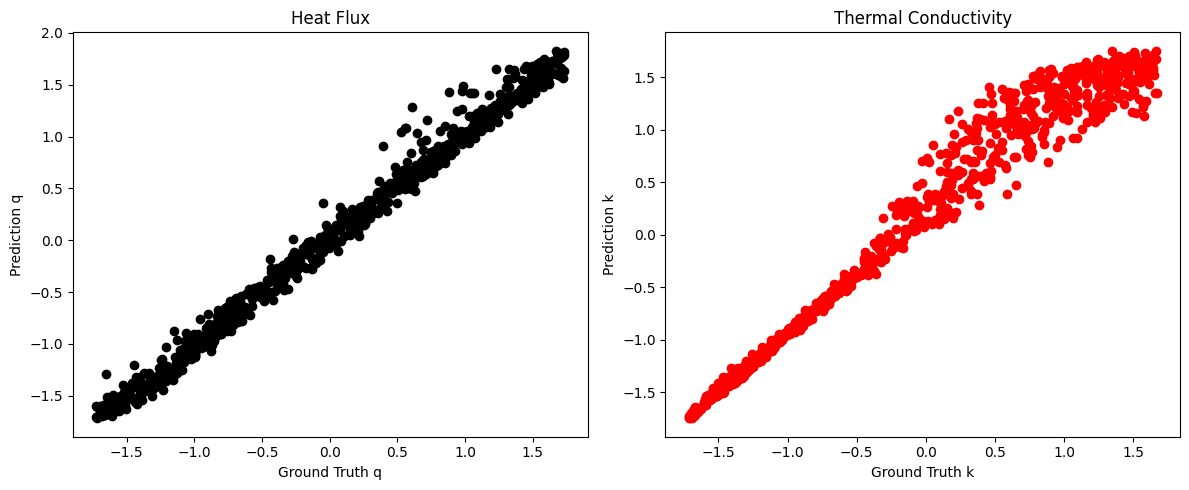

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

print("\t\t\tMean squared error: %.3f" % mean_squared_error(q_train, q_mean),"\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(k_train, k_mean))
print('\t\t\tR2 Variance score: %.3f' % r2_score(q_train, q_mean), '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_score(k_train, k_mean))
print("________________________________________________________________________")
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot)
axes[0].scatter(q_train, q_mean, color='black')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')

# Second Scatter Plot (right subplot)
axes[1].scatter(k_train, k_mean, color='red')  # Assuming you have y_train2 and r_mean2
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Plotting the results for Test Data

In [51]:
[z_mean_t, z_log_var_t, z_t, q_mean_t, q_log_var_t, q_t, k_mean_t, k_log_var_t, k_t] = encoder.predict([x_test],batch_size=batch_size)

7/7 [==============================] - 0s 2ms/step


			Mean squared error: 0.010 							Mean squared error: 0.083
			R2 Variance score: 0.990 							R2 Variance score: 0.915
________________________________________________________________________


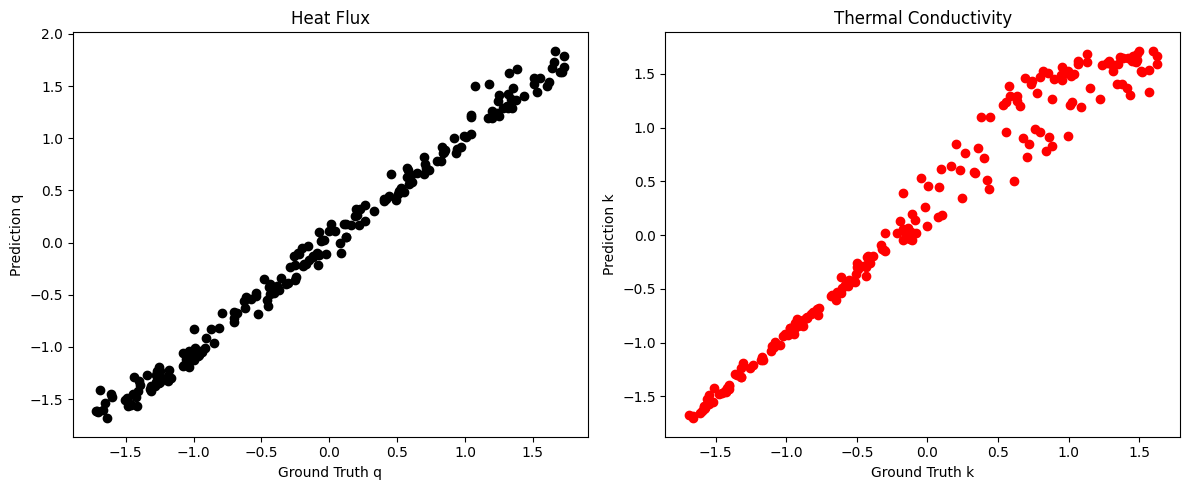

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

print("\t\t\tMean squared error: %.3f" % mean_squared_error(q_test, q_mean_t),"\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(k_test, k_mean_t))
print('\t\t\tR2 Variance score: %.3f' % r2_score(q_test, q_mean_t), '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_score(k_test, k_mean_t) )
print("________________________________________________________________________")
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot)
axes[0].scatter(q_test, q_mean_t, color='black')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')

# Second Scatter Plot (right subplot)
axes[1].scatter(k_test, k_mean_t, color='red')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [53]:
import numpy as np

# Column-wise concatenation for training data
train_combined = np.concatenate([x_train, q_mean, k_mean, q_log_var, k_log_var], axis=1)

# Column-wise concatenation for testing data
test_combined = np.concatenate([x_test, q_mean_t, k_mean_t, q_log_var_t, k_log_var_t], axis=1)

# Row-wise concatenation of the training and testing data
combined = np.concatenate([train_combined, test_combined], axis=0)

# Assuming 'scaler' was previously fitted to the training data including all features
combined_original = scaler.inverse_transform(combined)

			Mean squared error (q): 3.213
			R2 Variance score (q): 0.988
			Mean squared error (k): 16.075
			R2 Variance score (k): 0.918
________________________________________________________________________


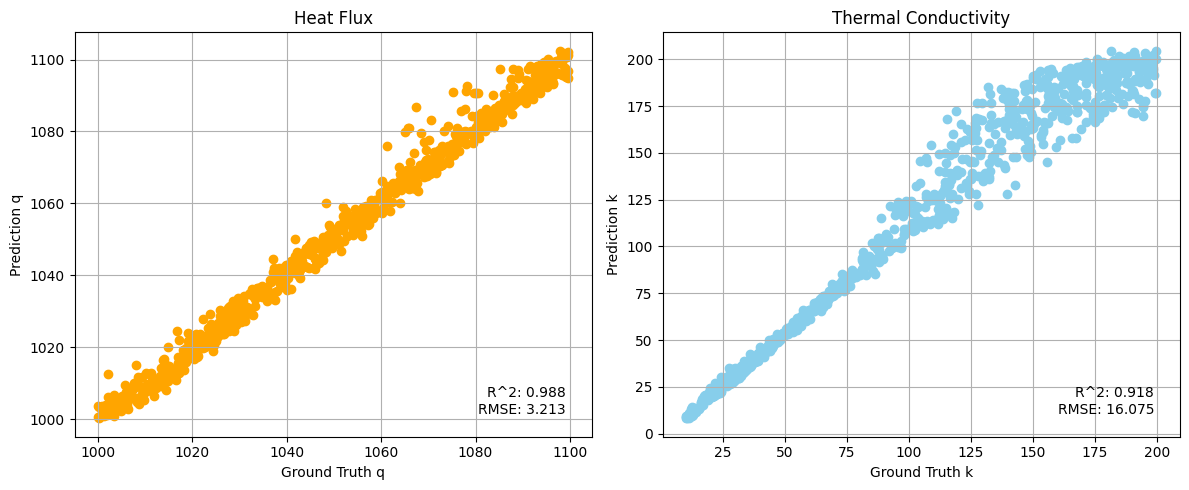

In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Calculate metrics
rmse_q = np.sqrt(mean_squared_error(data.iloc[:800, -4], combined_original[:800, -4]))
r2_q = r2_score(data.iloc[:800, -4], combined_original[:800, -4])
rmse_k = np.sqrt(mean_squared_error(data.iloc[:800, -3], combined_original[:800, -3]))
r2_k = r2_score(data.iloc[:800, -3], combined_original[:800, -3])

# Print metrics
print("\t\t\tMean squared error (q): %.3f" % rmse_q)
print("\t\t\tR2 Variance score (q): %.3f" % r2_q)
print("\t\t\tMean squared error (k): %.3f" % rmse_k)
print("\t\t\tR2 Variance score (k): %.3f" % r2_k)
print("________________________________________________________________________")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot for q)
axes[0].scatter(data.iloc[:800, -4], combined_original[:800, -4], color='orange')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')
axes[0].grid(True)
# Adding RMSE and R^2 text
axes[0].text(0.95, 0.05, f'R^2: {r2_q:.3f}\nRMSE: {rmse_q:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[0].transAxes, color='black', fontsize=10)

# Second Scatter Plot (right subplot for k)
axes[1].scatter(data.iloc[:800, -3], combined_original[:800, -3], color='skyblue')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')
axes[1].grid(True)
# Adding RMSE and R^2 text
axes[1].text(0.95, 0.05, f'R^2: {r2_k:.3f}\nRMSE: {rmse_k:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[1].transAxes, color='black', fontsize=10)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

			Mean squared error: 7.971 							Mean squared error: 262.221
			R2 Variance score: 0.990 							R2 Variance score: 0.915
________________________________________________________________________


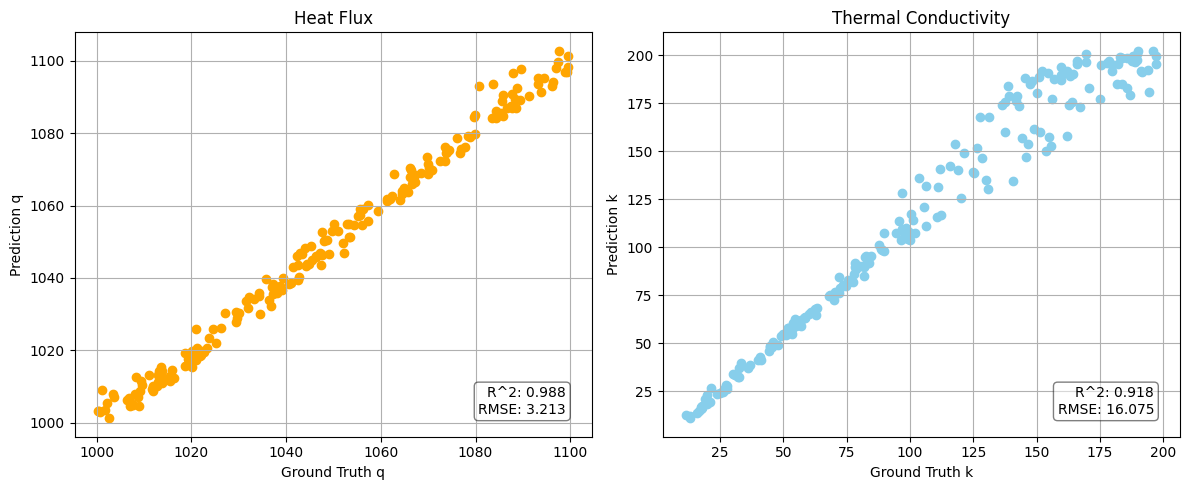

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming 'data' and 'combined_original' are previously defined pandas DataFrame and numpy array, respectively.

# Correctly call mean_squared_error by separating the arguments
print("\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[800:, -4], combined_original[800:, -4]),
      "\t\t\t\t\t\t\tMean squared error: %.3f" % mean_squared_error(data.iloc[800:, -3], combined_original[800:, -3]))
print('\t\t\tR2 Variance score: %.3f' % r2_score(data.iloc[800:, -4], combined_original[800:, -4]),
      '\t\t\t\t\t\t\tR2 Variance score: %.3f' % r2_score(data.iloc[800:, -3], combined_original[800:, -3]))
print("________________________________________________________________________")

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# First Scatter Plot (left subplot for q)
axes[0].scatter(data.iloc[800:, -4], combined_original[800:, -4], color='orange')
axes[0].set_xlabel('Ground Truth q')
axes[0].set_ylabel('Prediction q')
axes[0].set_title('Heat Flux')
axes[0].grid(True)
# Adding RMSE and R^2 text
axes[0].text(0.95, 0.05, f'R^2: {r2_q:.3f}\nRMSE: {rmse_q:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[0].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Second Scatter Plot (right subplot for k)
axes[1].scatter(data.iloc[800:, -3], combined_original[800:, -3], color='skyblue')
axes[1].set_xlabel('Ground Truth k')
axes[1].set_ylabel('Prediction k')
axes[1].set_title('Thermal Conductivity')
axes[1].grid(True)
# Adding RMSE and R^2 text
axes[1].text(0.95, 0.05, f'R^2: {r2_k:.3f}\nRMSE: {rmse_k:.3f}', verticalalignment='bottom', horizontalalignment='right', transform=axes[1].transAxes, color='black', fontsize=10, bbox=dict(boxstyle="round", facecolor='white', alpha=0.5))

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()